# Analyzing CIA Factbook Data Using SQLite and Python

In this project, I worked with data from the CIA World Factbook, a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information. The goal of this analysis is to to explore, analyze, and visualize data from this database.
 + [Data](https://github.com/factbook/factbook.sql/releases) is obatined from Dataquest bootcamp 

In [17]:
import sqlite3
import pandas as pd

# Read factbook database
conn = sqlite3.connect("factbook.db")
cursor = conn.cursor()
query = "SELECT * FROM sqlite_master WHERE type='table';"
cursor.execute(query).fetchall()

[('table',
  'facts',
  'facts',
  2,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float, "created_at" datetime, "updated_at" datetime)'),
 ('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)')]

In [21]:
#Inspect sqlite_sequence table
pd.read_sql_query(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


In [27]:
#Inspect facts table
query_facts = "SELECT * FROM facts limit 5;"
cursor.execute(query_facts).fetchmany(5)
pd.read_sql_query(query_facts, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## Population Summary Statistics
Let's start by calculating some summary statistics and look for any outlier countries.

In [32]:
query_facts = '''SELECT min(population) min_pop, max(population) max_pop, 
min(population_growth) min_pop_grwth, max(population_growth) max_pop_grwth
from facts;
'''
pd.read_sql_query(query_facts, conn)

,min_pop,max_pop,min_pop_grwth,max_pop_grwth
0,0,7256490011,0.0,4.02


+ there's a country with a population of 0
+ there's a country with a population of 7256490011 (or more than 7.2 billion people) 

Let us investigate these outliers

In [35]:
# Identify a country(s) where population of 0
query_facts = "SELECT * from facts where population =0;"
pd.read_sql_query(query_facts, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


In [36]:
# Identify a country(s) where population of 7.2 billion
query_facts = "SELECT * from facts where population =7256490011;"
pd.read_sql_query(query_facts, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


It seems like the table contains a row for Antarctica, which explains the population of 0. It also seems like the table contains a row for the whole world, which explains the population of over 7.2 billion. 

## Ananalyze population distribution per country

C:\Users\Tadesse\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3291: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002604D7D6C88>,
      dtype=object)

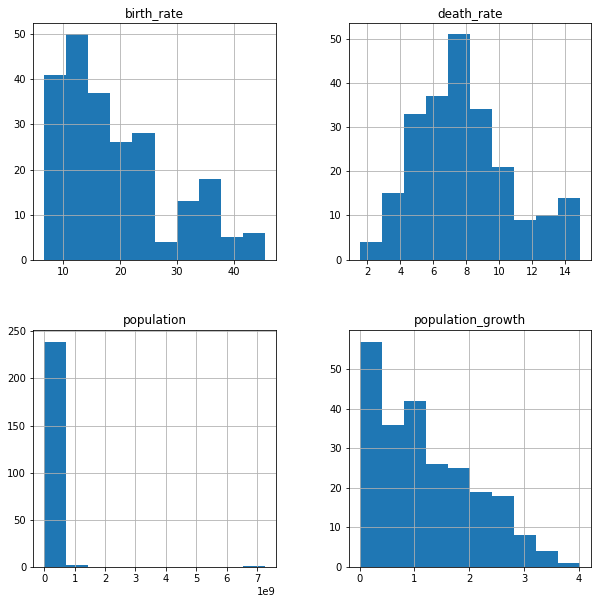

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize =(10,10))
ax = fig.add_subplot(111)
query_facts = '''SELECT population, population_growth, birth_rate, death_rate 
from facts 
where name != (SELECT max(population) from facts)and name != (SELECT min(population) from facts);'''
pd.read_sql_query(query_facts, conn).hist(ax=ax)

## countries have the highest population density

In [62]:
query_facts = '''SELECT name, population, area_land, round(cast (population as float)/cast(area_land as float)) pop_dens
from facts 
group by name
order by pop_dens DESC limit 5;'''
pd.read_sql_query(query_facts, conn)

,name,population,area_land,pop_dens
0,Macau,592731,28,21169.0
1,Monaco,30535,2,15268.0
2,Singapore,5674472,687,8260.0
3,Hong Kong,7141106,1073,6655.0
4,Gaza Strip,1869055,360,5192.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002604C230940>]],
      dtype=object)

<Figure size 720x720 with 0 Axes>

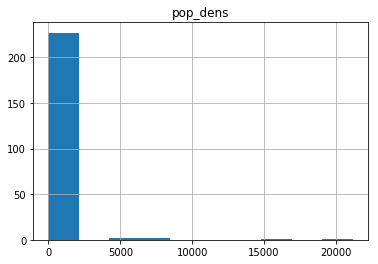

In [60]:
fig = plt.figure(figsize =(10,10))
query_facts = '''SELECT cast (population as float)/cast(area_land as float) pop_dens
from facts ;'''
pd.read_sql_query(query_facts, conn).hist()

# Countries with most water to land ration

In [63]:
query_facts = '''SELECT name, area_water, area_land, round(cast (area_water as float)/cast(area_land as float), 1) wat_land
from facts 
group by name
order by wat_land DESC limit 5;'''
pd.read_sql_query(query_facts, conn)

,name,area_water,area_land,wat_land
0,British Indian Ocean Territory,54340,60,905.7
1,Virgin Islands,1564,346,4.5
2,Puerto Rico,4921,8870,0.6
3,"Bahamas, The",3870,10010,0.4
4,Guinea-Bissau,8005,28120,0.3
